In [1]:
import os
import allel
import zarr
import pandas as pd
import h5py
import petl as etl
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import h5py
import pyfasta
import bcolz
import glob
import itertools

In [2]:
import sys
import gc
import datetime
import humanize
from humanize import naturalsize, intcomma, intword


def log(*msg):
    print(' '.join(map(str, msg)), file=sys.stdout)
    sys.stdout.flush()
    
from contextlib import contextmanager

@contextmanager
def timer(*msg):
    before = datetime.datetime.now()
    try:
        yield
    except:
        after = datetime.datetime.now()
        elapsed = (after - before).total_seconds()
        done = 'errored after %s' % humanize.naturaldelta(elapsed)
        if not msg:
            msg = done
        else:
            msg = ', '.join(map(str, msg)) + ', ' + done
        print(msg, file=sys.stderr)
        sys.stderr.flush()   
        raise
    else:
        after = datetime.datetime.now()
        elapsed = (after - before).total_seconds()
        done = 'done in %s' % humanize.naturaldelta(elapsed)
        if not msg:
            msg = done
        else:
            msg = ', '.join(map(str, msg)) + ', ' + done
        print(msg, file=sys.stdout)
        sys.stdout.flush()

In [3]:
tbl_samples = pd.read_csv("/kwiat/1/anopheles/ag1000g/data/phase2/release/AR1/samples/samples.meta.txt", sep = "\t")
tbl_samples

,ox_code,src_code,population,country,region,contributor,contact,year,m_s,sex,n_sequences,mean_coverage
0,AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo_Praso,David Weetman,NaN,2012.0,M,F,95033368,30.99
1,AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo_Praso,David Weetman,NaN,2012.0,M,F,95843804,31.70
2,AA0042-C,Takoradi_C7,GHcol,Ghana,Takoradi,David Weetman,NaN,2012.0,M,F,107420666,35.65
3,AA0043-C,Takoradi_H8,GHcol,Ghana,Takoradi,David Weetman,NaN,2012.0,M,F,95993752,29.46
4,AA0044-C,Takoradi_D10,GHcol,Ghana,Takoradi,David Weetman,NaN,2012.0,M,F,103044262,33.67
5,AA0048-C,Madina_A1,GHgam,Ghana,Madina,David Weetman,NaN,2012.0,S,F,101183648,32.64
6,AA0049-C,Madina_E3,GHcol,Ghana,Madina,David Weetman,NaN,2012.0,M,F,106641272,32.84
7,AA0050-C,Madina_E5,GHgam,Ghana,Madina,David Weetman,NaN,2012.0,S,F,93961924,29.82
8,AA0051-C,Twifo_Praso__C1,GHcol,Ghana,Twifo_Praso,David Weetman,NaN,2012.0,M,F,99910300,33.33
9,AA0052-C,Twifo_Praso__F2,GHcol,Ghana,Twifo_Praso,David Weetman,NaN,2012.0,M,F,100899280,32.29


In [84]:
phase2happath = '/kwiat/1/anopheles/ag1000g/data/phase2/release/AR1/haplotypes/main/zarr/ag1000g.phase2.ar1.haplotypes/3R'
calldata_hap_phase2= zarr.open(phase2happath)

In [85]:
calldata_hap_phase2.tree()

/
 ├── calldata
 │   └── GT (10752701, 1164, 2) int8
 ├── samples (1164,) |S8
 └── variants
     ├── ALT (10752701,) |S1
     ├── POS (10752701,) int32
     └── REF (10752701,) |S1

In [87]:
allel.SortedIndex(calldata_hap_phase2['variants']['POS'][:])

0,1,2,3,4,...,10752696,10752697,10752698,10752699,10752700
9526,9531,9544,9546,9549,...,53195257,53195262,53195269,53195273,53195279


In [88]:
fasta_fn = '/kwiat/vector/ag1000g/release/phase2.AR1/genome/agamP3/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP3.fa'
genome = pyfasta.Fasta(fasta_fn, key_fn=lambda k: k.split()[0])

In [89]:
sorted(genome.keys())

['2L', '2R', '3L', '3R', 'UNKN', 'X', 'Y_unplaced']

In [90]:
len(genome['3R'])

53200684

In [91]:
accessibility_fn = '/kwiat/vector/ag1000g/release/phase2.AR1/accessibility/accessibility.h5'
accessibility = h5py.File(accessibility_fn, mode='r')

-----------------------------------------------------

## DXY pairwise calc

In [92]:
dist_dn_template = os.path.join('dist_haps')
dist_fn_template = '{chrom}.{start:08d}.{stop:08d}.npy'

In [12]:
def compute_dxy_distance_matrices(chrom, window_size):
    dist_dn = dist_dn_template.format(metric='dxy', window_size=window_size)
    if not os.path.exists(dist_dn):
        os.makedirs(dist_dn)
        
    # open haplotypes
    callset = zarr.open(phase2happath)
    
    # load accessibility map
    is_accessible = accessibility[chrom]['is_accessible'][:]
    
    # determine accessible positions
    pos_accessible, = np.nonzero(is_accessible)
    
    # define equally accessible windows
    window_starts = pos_accessible[0:None:window_size]
    window_stops = pos_accessible[window_size-1:None:window_size]
    
    # add final window to end of chromosome
    window_starts = np.append(window_starts, [window_stops[-1] + 1])
    window_stops = np.append(window_stops, [len(genome[chrom])])
    
    # load variant positions
    pos = allel.SortedIndex(calldata_hap_phase2[chrom]['variants']['POS'][:])

    # iterate over windows
    for window_start, window_stop in zip(window_starts, window_stops):
        
        # distance matrix file name
        dist_fn = dist_fn_template.format(chrom=chrom, start=window_start, stop=window_stop)
        dist_path = os.path.join(dist_dn, dist_fn)
        
        # stay dry
        if os.path.exists(dist_path):
            log('skipping', dist_path)
            
        else:
            log('building', dist_path)
            gc.collect()
            
            with timer():
                
                # locate the window
                loc = pos.locate_range(window_start, window_stop)
                print (loc.start, loc.stop)

                # load data
                genotypes_phase2_call = calldata_hap_phase2[chrom]["calldata/GT"]
                genotypes_phase2 = allel.GenotypeChunkedArray(genotypes_phase2_call[loc])
                haplotypes = genotypes_phase2.to_haplotypes()
                n_variants = genotypes_phase2.shape[0]
                log('variants:', n_variants)


                # compute hamming distance
                dist = allel.pairwise_distance(haplotypes[:], metric='hamming')
                log('hamming distance, max:', dist.max(), ', min:', dist.min())

                # adjust by accessible window size
                n_bases = np.count_nonzero(is_accessible[window_start:window_stop+1])
                log('window accessible size:', n_bases)
                dist = dist * n_variants / n_bases
                log('dxy distance, max:', dist.max(), ', min:', dist.min())

                # save
                np.save(dist_path, dist)

In [15]:
dxy_3L = compute_dxy_distance_matrices('3L', 100000)

skipping dist_haps/3L.00009778.00730787.npy
skipping dist_haps/3L.00730788.01243275.npy
skipping dist_haps/3L.01243276.01622713.npy
skipping dist_haps/3L.01622714.01833911.npy
skipping dist_haps/3L.01833912.01989789.npy
skipping dist_haps/3L.01989790.02108439.npy
skipping dist_haps/3L.02108440.02239834.npy
skipping dist_haps/3L.02239835.02412740.npy
skipping dist_haps/3L.02412741.02586161.npy
skipping dist_haps/3L.02586162.02773590.npy
skipping dist_haps/3L.02773591.02919374.npy
skipping dist_haps/3L.02919375.03073996.npy
skipping dist_haps/3L.03073997.03235327.npy
skipping dist_haps/3L.03235328.03378695.npy
skipping dist_haps/3L.03378696.03487521.npy
skipping dist_haps/3L.03487522.03595558.npy
skipping dist_haps/3L.03595559.03719733.npy
skipping dist_haps/3L.03719734.03884028.npy
skipping dist_haps/3L.03884029.04028601.npy
skipping dist_haps/3L.04028602.04210838.npy
skipping dist_haps/3L.04210839.04880931.npy
skipping dist_haps/3L.04880932.05102740.npy
skipping dist_haps/3L.05102741.0

In [16]:
dxy_3R = compute_dxy_distance_matrices('3R', 100000)

skipping dist_haps/3R.00000020.00134416.npy
skipping dist_haps/3R.00134417.00243509.npy
skipping dist_haps/3R.00243510.00352301.npy
skipping dist_haps/3R.00352302.00473621.npy
skipping dist_haps/3R.00473622.00577607.npy
skipping dist_haps/3R.00577608.00690433.npy
skipping dist_haps/3R.00690434.00801223.npy
skipping dist_haps/3R.00801224.00915204.npy
skipping dist_haps/3R.00915205.01030193.npy
skipping dist_haps/3R.01030194.01147657.npy
skipping dist_haps/3R.01147658.01270736.npy
skipping dist_haps/3R.01270737.01395739.npy
skipping dist_haps/3R.01395740.01525501.npy
skipping dist_haps/3R.01525502.01647090.npy
skipping dist_haps/3R.01647091.01767431.npy
skipping dist_haps/3R.01767432.01903815.npy
skipping dist_haps/3R.01903816.02013366.npy
skipping dist_haps/3R.02013367.02125220.npy
skipping dist_haps/3R.02125221.02333172.npy
skipping dist_haps/3R.02333173.02447612.npy
skipping dist_haps/3R.02447613.02564468.npy
skipping dist_haps/3R.02564469.02677460.npy
skipping dist_haps/3R.02677461.0

--------------------------------

## DXY plotting

In [17]:
palette = sns.color_palette()

In [18]:
distscan_dir = 'dist_haps/'
!ls -lh {distscan_dir}* | head

-rw-r--r-- 1 beniamino kwiat-cluster-users 21M Sep 13 11:20 dist_haps/3L.00009778.00730787.npy
-rw-r--r-- 1 beniamino kwiat-cluster-users 21M Sep 13 11:21 dist_haps/3L.00730788.01243275.npy
-rw-r--r-- 1 beniamino kwiat-cluster-users 21M Sep 13 11:21 dist_haps/3L.01243276.01622713.npy
-rw-r--r-- 1 beniamino kwiat-cluster-users 21M Sep 13 11:22 dist_haps/3L.01622714.01833911.npy
-rw-r--r-- 1 beniamino kwiat-cluster-users 21M Sep 13 11:23 dist_haps/3L.01833912.01989789.npy
-rw-r--r-- 1 beniamino kwiat-cluster-users 21M Sep 13 11:23 dist_haps/3L.01989790.02108439.npy
-rw-r--r-- 1 beniamino kwiat-cluster-users 21M Sep 13 11:24 dist_haps/3L.02108440.02239834.npy
-rw-r--r-- 1 beniamino kwiat-cluster-users 21M Sep 13 11:25 dist_haps/3L.02239835.02412740.npy
-rw-r--r-- 1 beniamino kwiat-cluster-users 21M Sep 13 11:25 dist_haps/3L.02412741.02586161.npy
-rw-r--r-- 1 beniamino kwiat-cluster-users 21M Sep 13 11:26 dist_haps/3L.02586162.02773590.npy
ls: write error: Broken pipe


In [124]:
def open_dscan(chrom):

    # find the underlying matrix file names, we need these to get window boundaries
    dfns = sorted(glob.glob(os.path.join(distscan_dir, chrom + '*.npy')))
    bnms = [os.path.basename(f) for f in dfns]
    windows = np.array([[int(b.split('.')[1]), int(b.split('.')[2])] for b in bnms])
    n_windows = len(windows)
    log(n_windows, 'windows')

    # compile into a single array
    dscan_rootdir = os.path.join(distscan_dir, '%s.bcolz' % chrom)
    if not os.path.exists(dscan_rootdir):
        log('loading', dscan_rootdir)

        # load up the first matrix to determine shape
        d = np.load(dfns[0])
        n_pairs = d.shape[0]
        
        log(n_pairs, 'pairs')

        # setup bcolz array
        dscan = bcolz.carray(np.empty((0, n_pairs), dtype='f4'), 
                             cparams=bcolz.cparams(cname='zlib', clevel=1),
                             rootdir=dscan_rootdir,
                             mode='w',
                             expectedlen=n_windows)

        # load one row at a time
        for i, dfn in enumerate(dfns):
            if i > 0 and i % 20 == 0:
                log(i, dfn)
            dscan.append(np.load(dfn, mmap_mode='r'))
            dscan.flush()
        
    # open/re-open in read-only mode
    dscan = bcolz.carray(rootdir=dscan_rootdir, mode='r')

    return windows, dscan

In [125]:
def sample_to_haplotype_indices(sidx):
    return list(itertools.chain(*[[ix*2, ix*2+1] for ix in sidx])) 

In [126]:
def extract_2pop_dscan(chrom, pop1, pop2):

    callset = zarr.group(phase2happath)
    samples = [str(s, 'ascii') for s in callset['samples'][:]]
    n_samples = len(samples)
    n_haplotypes = 2 * n_samples
    
    # load dscan
    windows, dscan = open_dscan(chrom)

    # locate sample indices
    pop1_sample_indices=tbl_samples.population[tbl_samples.population == pop1].index.tolist()
    pop2_sample_indices=tbl_samples.population[tbl_samples.population == pop2].index.tolist()

    # locate haplotype indices
    pop1_haplotype_indices = sample_to_haplotype_indices(pop1_sample_indices)
    pop2_haplotype_indices = sample_to_haplotype_indices(pop2_sample_indices)
    
    # locate indices of pairwise comparisons within and between populations
    dw1_ix = allel.condensed_coords_within(pop1_haplotype_indices, n_haplotypes)
    dw2_ix = allel.condensed_coords_within(pop2_haplotype_indices, n_haplotypes)
    db_ix = allel.condensed_coords_between(pop1_haplotype_indices, pop2_haplotype_indices, n_haplotypes)
    
    # extract pairwise distances
    dw1 = allel.chunked.core.take(dscan, dw1_ix, axis=1)[:]
    dw2 = allel.chunked.core.take(dscan, dw2_ix, axis=1)[:]
    db = allel.chunked.core.take(dscan, db_ix, axis=1)[:]
    
   
    return windows, dw1, dw2, db


In [127]:
def plot_dist_scan(windows, d, ylim=(0, 0.016), title=None, color=None, ax=None):
    
    # set up figure
    if ax is None:
        fig, ax = subplots(figsize=(8, 1.5))
    if title is not None:
        ax.set_title(title, fontweight='bold')

    # window centres
    x = np.array(windows).mean(axis=1)

    # median
    y = np.median(d, axis=1)
    ax.plot(x, y, color=color, lw=1)
    
    # interquartile range
    y1 = np.percentile(d, 25, axis=1)
    y2 = np.percentile(d, 75, axis=1)
    ax.fill_between(x, y1, y2, color=color, alpha=.6)
    
    # 5-95 range
    y1 = np.percentile(d, 5, axis=1)
    y2 = np.percentile(d, 95, axis=1)
    ax.fill_between(x, y1, y2, color=color, alpha=.4)
    
    # total range
    y1 = d.min(axis=1)
    y2 = d.max(axis=1)
    ax.fill_between(x, y1, y2, color=color, alpha=.2)
    
    # tidy up
    ax.set_ylim(*ylim)
    
    # legend
    handles = list()
    # median
    l = plt.Line2D([], [], color=color, linestyle='-', linewidth=2, label='median')
    handles.append(l)
    # percentiles
    r = plt.Rectangle([0, 0], 1, 1, color=color, alpha=.6, lw=0, label='25-75th percentiles')
    handles.append(r)
    r = plt.Rectangle([0, 0], 1, 1, color=color, alpha=.4, lw=0, label='5-95th percentiles')
    handles.append(r)
    r = plt.Rectangle([0, 0], 1, 1, color=color, alpha=.2, lw=0, label='min-max')
    handles.append(r)
    ax.legend(handles=handles, bbox_to_anchor=[1, 1], loc='upper left')    
    ax.set_yticks([0, .005, .01, .015])
    ax.set_xlim(0, windows[-1, -1])
    

In [128]:
def plot_gmin(windows, d, title=None, ax=None):
    
    # set up figure
    if ax is None:
        fig, ax = subplots(figsize=(8, 1.5))
    if title is not None:
        ax.set_title(title, fontweight='bold')

    # window centres
    x = np.array(windows).mean(axis=1)

    # Gmin
    y = d.min(axis=1) / d.mean(axis=1)
    ax.plot(x, y, color='k', lw=1, linestyle='-')
        
    # tidy up
    ax.set_ylabel(r'$G_{min}$', rotation=0, ha='right', va='center')
    ax.set_xlim(0, windows[-1, -1])
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 1])

In [129]:
autosomes = ['3L', '3R']

In [130]:
def run_2pop_analysis(pop1, pop2):
    for chrom in autosomes:
        fig = plt.figure(figsize=(13, 11))
        windows, dw1, dw2, db = extract_2pop_dscan(chrom, pop1, pop2)
        
        ax = fig.add_subplot(4, 1, 1)
        sns.despine(ax=ax, bottom=True, offset=5)
        plot_dist_scan(windows, dw1, title='%s, %s' % (pop1, chrom), color=palette[0], ax=ax)
        ax.set_xticks([])
        ax.set_ylabel(r'$\pi$', rotation=0, ha='right', va='center')
        
        ax = fig.add_subplot(4, 1, 2)
        sns.despine(ax=ax, bottom=True, offset=5)
        plot_dist_scan(windows, dw2, title='%s, %s' % (pop2, chrom), color=palette[1], ax=ax)
        ax.set_xticks([])
        ax.set_ylabel(r'$\pi$', rotation=0, ha='right', va='center')
        
        ax = fig.add_subplot(4, 1, 3)
        sns.despine(ax=ax, bottom=True, offset=5)
        plot_dist_scan(windows, db, title='%s/%s, %s' % (pop1, pop2, chrom), color=palette[2], ax=ax)
        ax.set_xticks([])
        ax.set_ylabel(r'$d_{XY}$', rotation=0, ha='right', va='center')

        ax = fig.add_subplot(4, 1, 4)
        sns.despine(ax=ax, offset=5)
        plot_gmin(windows, db, title='%s/%s, %s' % (pop1, pop2, chrom), ax=ax)
        ax.set_xlabel('position (bp)')
        
        fig.tight_layout()
        plt.show()

250 windows


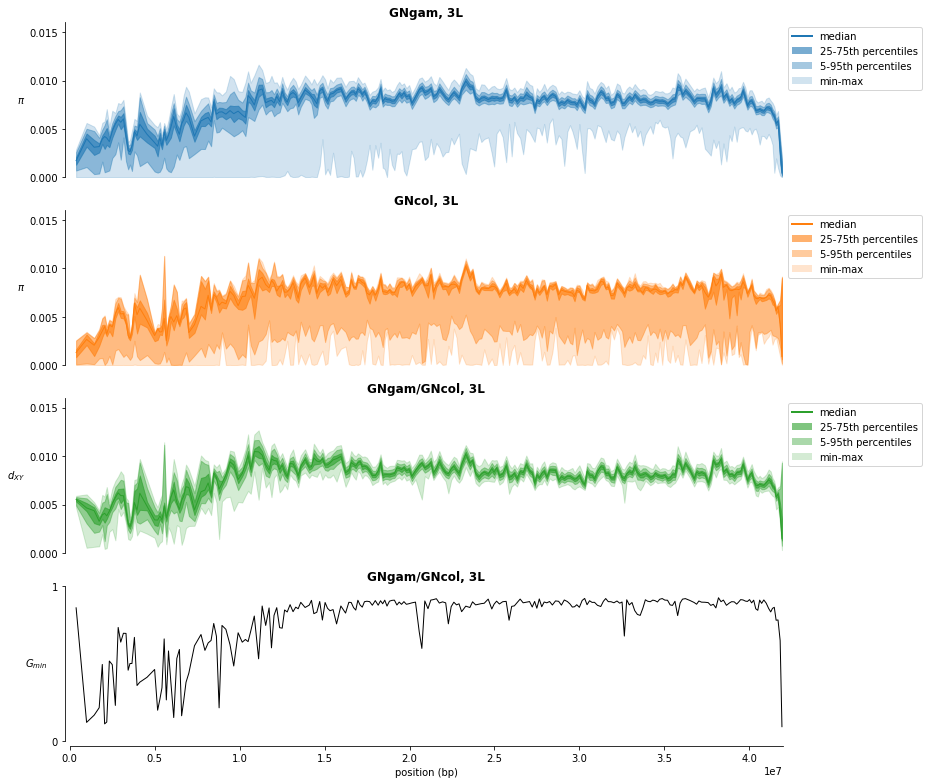

325 windows


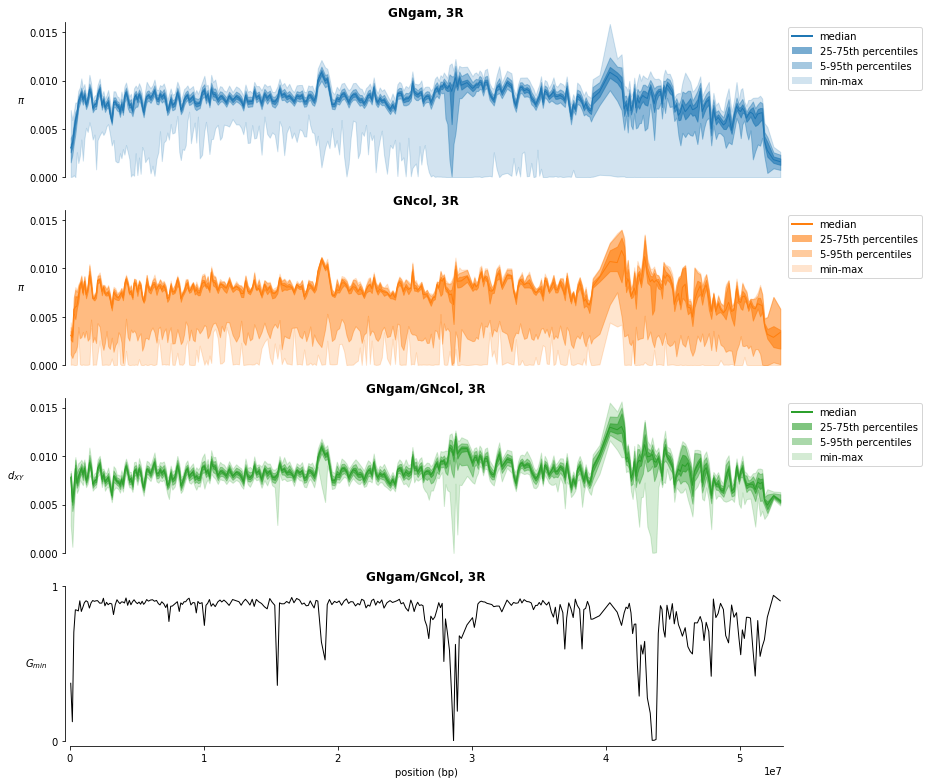

In [131]:
run_2pop_analysis('GNgam', 'GNcol')

250 windows


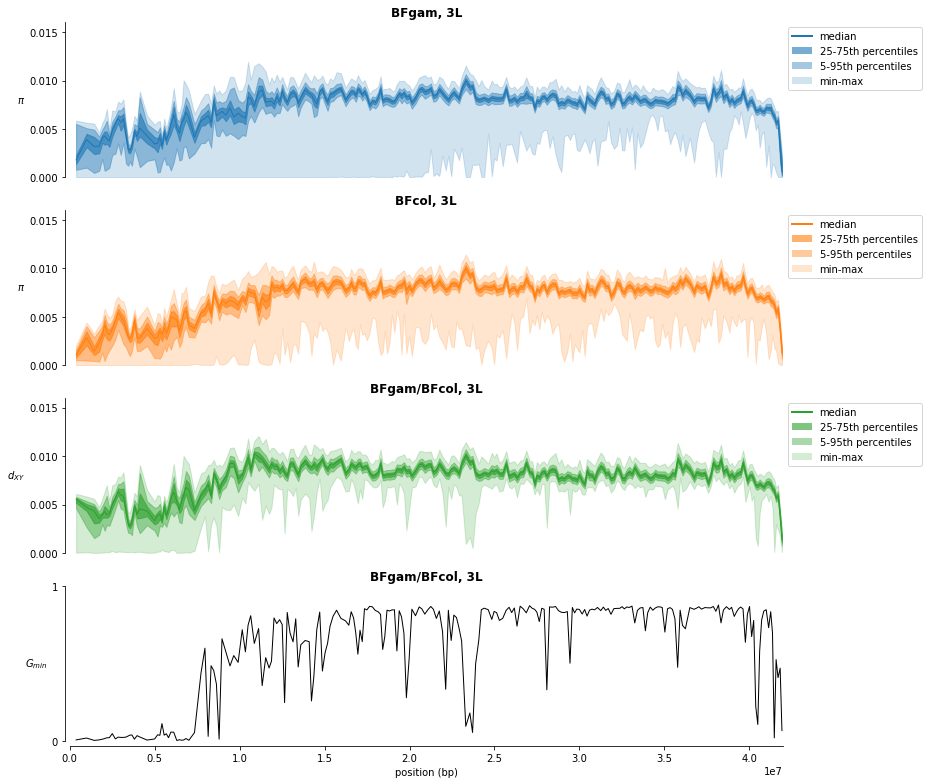

325 windows


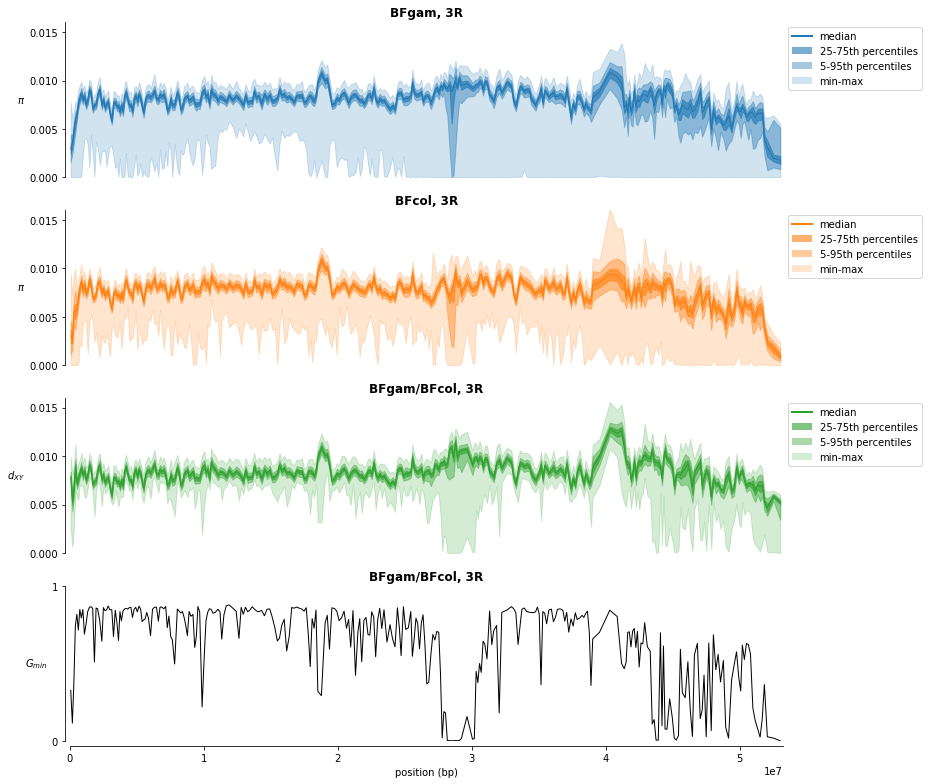

In [132]:
run_2pop_analysis('BFgam', 'BFcol')

250 windows


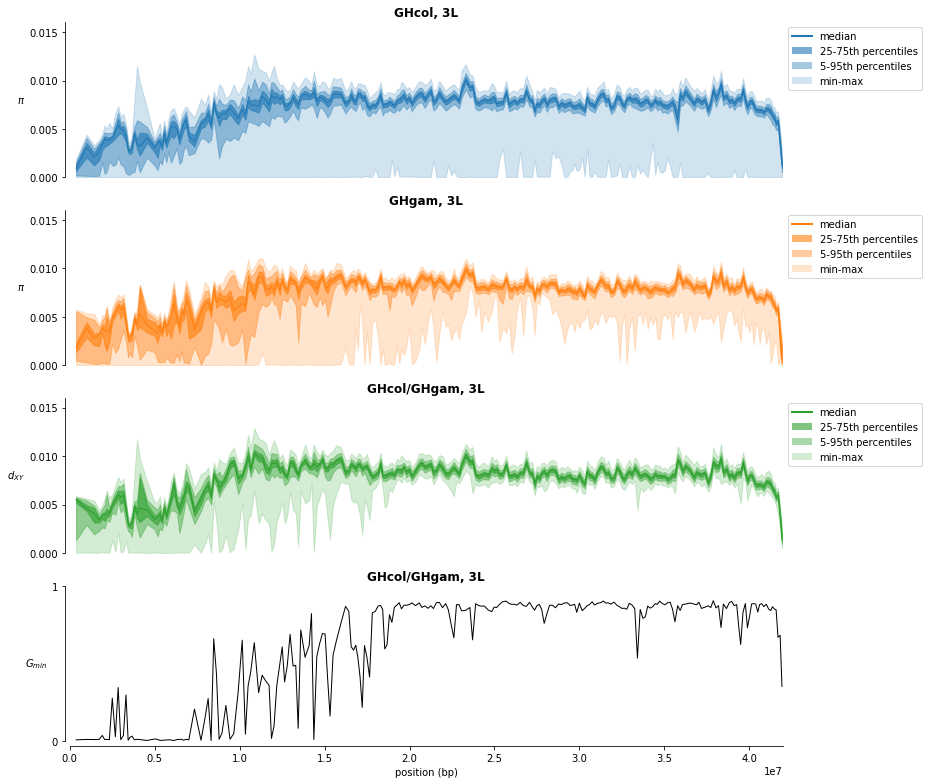

325 windows


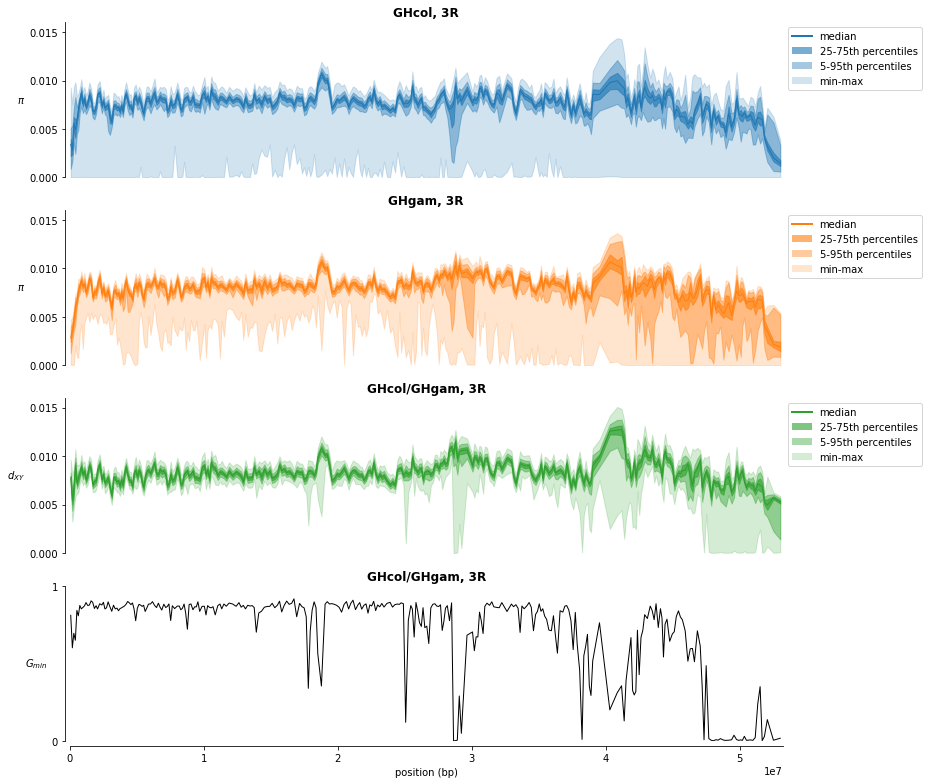

In [133]:
run_2pop_analysis('GHcol', 'GHgam')